In [3]:
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [135]:
n = 500
p = 1000
m = 1

In [136]:
lambda_ = np.random.random(n)
lambda_ /= lambda_.sum()

e = np.matrix(np.random.random(size=(n, n)) + 1)

G_wave = sum([lambda_[i] * e[:,i].dot(e[:,i].T) for i in range(n)])
G_wave = np.array(G_wave)

Li = np.diag(G_wave)

In [137]:
def test_G_correctness(G):
    return np.all(G == G.T) and \
           np.linalg.eig(G)[0].min() >= 0 and \
           G_wave.min() >= 0 and \
           G_wave.min() <= 4

In [138]:
test_G_correctness(G_wave)

True

In [139]:
sparsity = 0.01

A = np.zeros(shape=(p, n))
A[
    np.random.randint(p, size=int(sparsity*(p*n))), 
    np.random.randint(n, size=int(sparsity*(p*n)))
] = np.random.random(int(sparsity*(p*n))) * 2 - 1

In [455]:
# Log sum exp trick
def h(x):
    t = np.dot(A, x)
    u = t.max()
    t -= u
    return u + np.log(np.exp(t).sum())

g = lambda x: min(0.5 * np.dot(x, np.dot(G_wave, x)), 1e142)
f = lambda x: g(x) + h(x)

# Exp-normalize trick
def grad_h(x):
    s = np.dot(A, x)
    b = s.max()
    z = np.exp(s - b)
    return np.dot(A.T, z) / np.dot(np.ones(p), z)

grad_g = lambda x: np.dot(G_wave, x)
grad_f = lambda x: grad_g(x) + grad_h(x)

In [456]:
def phi(zeta, zeta_k, zeta_0, L_h, L):
    return np.dot(grad_h(zeta_k), zeta - zeta_k) + g(zeta) + \
           0.5 * L_h * np.linalg.norm(zeta - zeta_k)**2 + \
           0.5 * L * np.linalg.norm(zeta - zeta_0)**2

def grad_phi(zeta, zeta_k, zeta_0, L_h, L):
    return grad_h(zeta_k) + grad_g(zeta) + \
           L_h * (zeta - zeta_k) + \
           L * (zeta - zeta_0)

In [524]:
def solve_quadratic(a, b, c):
    D = b**2 - 4*a*c
    return (-b + np.sqrt(D)) / (2*a)

def nesterov(func, grad_func, x0, T=100, L_add=0, restart=None, beta=1/2, return_losses=True, time_scale=False):
    x = x0.copy()
    v = x0.copy()
    
    A = 0
    S = ((Li+L_add)**beta).sum()
    
    losses = []
    times = []
    
    time_start = time.time()
    
    for k in range(T):
        i = int(np.random.choice(np.linspace(0, n-1, n), 
                                 p=(Li+L_add)**beta/S))
        a = np.roots([S**2, -1, -A]).max()
        A = A + a
        alpha = a / A
        
        y = (1 - alpha) * x + alpha * v
        x = y - (1 / (Li[i]+L_add)) * grad_func(y)[i] * np.eye(n)[i]
        v = v - (a * S) / ((Li[i]+L_add)**beta) * grad_func(y)[i] * np.eye(n)[i]
        
        if restart is not None and k % restart == 0:
            v = x.copy()
            
        if time_scale:
            times.append(time.time() - time_start)
        
        losses.append(f(x))
        print(f(x))
    
    if return_losses and time_scale:
        return x, np.array(losses), np.array(times)
    elif return_losses:
        return x, np.array(losses)
    else:
        return x

In [453]:
def CLCM(func, grad_func, x0, T=100, L_add=0, restart=None, beta=1/2, return_losses=True):
    x = x0.copy()
    y = x0.copy()
    z = x0.copy()
    
    S = ((Li+L_add)**beta).sum()
    p = ((Li+L_add)**beta)/S
    L_hat = ((Li+L_add)**beta).sum()**2
    
    losses = []
    
    for k in range(T):
        i = int(np.random.choice(np.linspace(0, n-1, n), p=p))
        
        tau = 2 / (k + 2)
        h = (k + 2) / (2 * L_hat)
        
        x = tau * z + (1 - tau) * y
        y = x - 1 / (Li[i]+L_add) * grad_func(x)[i] * np.eye(n)[i]
        z = z - h / p * grad_func(x)[i] * np.eye(n)[i]
        
        if restart is not None and k % restart == 0:
            y = x.copy()
            z = x.copy()
        
        losses.append(func(x))
        print(f(x))
    
    if return_losses:
        return x, np.array(losses)
    else:
        return x

In [401]:
Lh = max([np.linalg.norm(A[:, k])**2 for k in range(n)])
L = Lh

In [402]:
x_0 = np.random.random(n)

In [538]:
def grad_composite(zeta0, L, Lh, time_scale):
    zeta = zeta0.copy()
    history_comp = []
    
    times = []
    
    for i in range(1):
        time_start = time.time()
        if time_scale:
            zeta, history_inner, times_inner = nesterov(
                lambda zeta_var: phi(zeta_var, zeta, zeta0, Lh, L),
                lambda zeta_var: grad_phi(zeta_var, zeta, zeta0, Lh, L),
                zeta.copy(),
                T=100,
                L_add=L+Lh,
                restart=None,
                return_losses=True,
                time_scale=True
            )
        else:
            zeta, history_inner = nesterov(
                lambda zeta_var: phi(zeta_var, zeta, zeta0, Lh, L),
                lambda zeta_var: grad_phi(zeta_var, zeta, zeta0, Lh, L),
                zeta.copy(),
                T=100,
                L_add=L+Lh,
                restart=None,
                return_losses=True,
                time_scale=False
            )
            
        times += (times_inner + time_start).tolist()
        history_comp += history_inner.tolist()
        
        if np.linalg.norm(grad_f(zeta) + L*(zeta - zeta0)) <= L / 2 * np.linalg.norm(zeta - zeta0):
            break
    
    if time_scale:
        return zeta, history_comp, times
    else:
        return zeta, history_comp

In [539]:
def ms_acc_prox_method(x0, L, Lh, T, time_scale):
    x = x0.copy()
    y = x0.copy()
    z = x0.copy()

    history = []
    times = []
    
    Ak = 0
    
    for it in range(T):
        time_start = time.time()
        ak = (1/L + np.sqrt(1/L/L + 4 * Ak / L)) / 2
        Ak_new = Ak + ak
        
        x = (Ak / Ak_new) * y + (ak / Ak_new) * z
        if time_scale:
            y, history_comp, times_comp = grad_composite(x, Lh, L, time_scale=True)
        else:
            y, history_comp = grad_composite(x, Lh, L, time_scale=False)
            
        print("y", f(y))
        
        print("--", ak)
        z = z - ak*0.1*grad_f(y)
        print("z", f(z))
        
        Ak = Ak_new
        
        times += (np.array(times_comp) + time_start).tolist()
        history += history_comp
        
    if time_scale:
        return y, np.array(history), times
    else:
        return y, np.array(history)

In [511]:
zeta, losses = nesterov(
    f,
    grad_f,
    x_0,
    T=1000,
    L_add=0,
    restart=None
)

2666.9969748830235
1423.072708160699
958.5145944024717
800.2207438273595
646.8483806964045
544.3201320450504
485.5176429530485
403.66814720467784
362.85464329476133
326.20506160112444
409.8466635824807
366.31842819130424
356.830057918594
314.6057782005347
292.3956395029357
273.3368065890718
262.4912386637558
248.15913105596888
224.982473914851
200.1097427145846
221.3661088944291
211.31884362335015
199.24512648914884
178.69392040147272
170.47854785952285
153.84804703826373
144.30150185669618
129.66210740506034
127.83935317674558
120.2004524760653
133.17644151057982
130.60870726412597
124.53724308617487
117.71430165493523
120.60379049669305
116.81611359334329
111.70098041828338
108.60351197416863
122.95530061023697
118.1281646429676
127.48502484271576
120.33986214867156
117.21559376233239
110.96416841538041
107.93686236260604
102.33141651847268
100.54148402707263
97.22470194938641
93.92594660156507
91.68529560479807
89.50491803467804
84.3299490766885
79.46630984424797
75.59467030285968
7

13.887957452401036
13.923466591807689
13.915106633694563
13.920911468629948
13.926607930526238
13.957265925856781
13.949353154331073
13.921791537913855
13.907541765682621
13.919818173037395
13.917432328675382
13.923212294927986
13.940053813157473
13.897835775960031
13.911478809411133
13.906355291685141
13.890142959848692
13.91336845602071
13.919746306256815
13.894657323569035
13.868870408979284
13.87089981681901
13.829129427154312
13.806562351517366
13.790709678972515
13.74134525134648
13.733622391635496
13.696915916418604
13.693086665812096
13.650752851618932
13.645279350404596
13.62174704965737
13.598259056427278
13.597544496133477
13.586109350579127
13.582463364646005
13.589033965560871
13.585212808282257
13.56541720431341
13.583297132273964
13.55967492989475
13.561831620014932
13.546819620576914
13.580307401907508
13.581335250852211
13.588848351037235
13.60245427314349
13.628622901383505
13.648604477611762
13.652023348570212
13.632069851906355
13.596279372253312
13.58702687670322
1

11.802942324868578
11.79937831790713
11.802076170100724
11.798384783513123
11.796586149557541
11.78982468866159
11.790431160852432
11.77916391470172
11.77728058477718
11.777238374410803
11.775290029235503
11.772498340712794
11.769737923355098
11.771621541246589
11.765848133616291
11.758730487980262
11.75692416337819
11.757414352600161
11.744469519302797
11.743026405250585
11.73797617778746
11.73833228958683
11.733035633464866
11.733521843684745
11.729350932511593
11.730200277523739
11.729384519805322
11.728872761058092
11.730795861648105
11.735512559238035
11.727927894203598
11.722081000335486
11.709513972185821
11.703883413874944
11.695531513526715
11.692840018093182
11.692339311770965
11.686561108832354
11.686255828448243
11.689202117609394
11.686285849439201
11.680956505852999
11.681218089211464
11.674293495502743
11.670433164958908
11.664689052608235
11.664233305033509


In [512]:
f_opt = min(
    losses_ms.min(),
    losses.min()
)

In [4]:
import pickle

# with open("data/losses_ms.data", "wb") as file:
#     pickle.dump(losses_ms, file)
#     
# with open("data/losses.data", "wb") as file:
#     pickle.dump(losses, file)

In [5]:
with open("data/losses_ms.data", "rb") as file:
    losses_ms = pickle.load(file)
    
with open("data/losses.data", "rb") as file:
    losses = pickle.load(file)

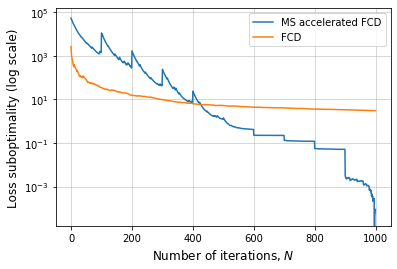

In [9]:
plt.semilogy(losses_ms - f_opt, 
             label="MS accelerated FCD")
plt.semilogy(losses - f_opt, label="FCD")
plt.grid(linewidth=0.5)

plt.xlabel(r"Number of iterations, $N$", fontsize=12)
plt.ylabel(r"Loss suboptimality (log scale)", fontsize=12)
plt.legend()

In [554]:
zeta_times, losses_times, times = nesterov(
    f,
    grad_f,
    x_0,
    T=3000,
    L_add=0,
    restart=None,
    time_scale=True
)

2792.5723696861
1608.4762255515564
1105.261816112519
773.2958439846315
603.5996170721419
514.6843115073435
432.0702944937925
343.66364764835487
320.63605568843286
277.69517222857746
278.61320527034854
263.81682396283594
235.40529693751284
201.06352624374472
193.60271271560504
181.75448098621965
178.07524347518807
168.31582010233228
162.78016095869157
154.53578221749476
146.3147024335614
145.05992701897537
130.9720410208482
131.90812103290898
128.25564609476078
118.68265671639026
115.35489763683786
111.78256843675526
115.87036119612884
109.72873596047216
104.35189647376987
103.71791257603817
98.07926380994239
93.82977616113445
108.35338232675436
104.98565643783606
99.99027633377415
99.77706098145926
95.59230574733935
91.33546353892548
87.18696004136324
86.88324137173309
89.48652383448737
87.48055492693257
90.85906100674914
85.17545661386417
84.6607159569365
84.700492516629
84.2137395968762
81.80282780064168
80.20267776418756
79.26137297171192
76.53141401573811
72.45148448568524
70.21099

14.049120617508361
14.061229935665676
14.001544039339814
13.97364693517672
13.95882061421139
13.913990668651685
13.882060962046484
13.867262642455213
13.866316052040442
13.866558226842773
13.853483402520025
13.856073075178806
13.83710496657126
13.779519927079996
13.796499739331335
13.84339978441488
13.801269667557445
13.821647721870068
13.774892209378727
13.733674178101552
13.738961204719912
13.746160440453647
13.75453849296606
13.731599729861541
13.722501354488
13.714896105414184
13.704464740257773
13.666374291547761
13.667635258302585
13.620144686563801
13.63864406856343
13.683343611338698
13.696059873500598
13.713729800641987
13.689844240457587
13.671434767727574
13.660350556370261
13.606896886832542
13.624178121659824
13.616005532236358
13.595941898663396
13.599566108120694
13.540800113686029
13.52997477317923
13.49328563307244
13.494835725860426
13.496091566624973
13.500521430535759
13.50851440721474
13.541499803315972
13.518159977264567
13.500796141968646
13.50323146497562
13.476

11.395197067355657
11.394149913727993
11.394855699334794
11.384254440939754
11.383373406871351
11.376449694423876
11.374179347551113
11.374791936250098
11.375228644744855
11.378001039789485
11.374444106034268
11.37562945542372
11.380092558393477
11.380239341274287
11.381230868412985
11.373868693778988
11.37301580270847
11.363862999980462
11.361611540457615
11.364448694597424
11.362892602885342
11.356835355576813
11.357254043534056
11.359206373934406
11.353622892361761
11.354550123101069
11.35716071401517
11.34954620148389
11.34758707785776
11.34458980503533
11.338270117836839
11.331122692733077
11.329283851095138
11.328714236262726
11.326466925784253
11.32762025935119
11.325348368910708
11.32668017753059
11.325067651819523
11.320146531078125
11.320336811786635
11.315015117307276
11.313045062996004
11.31431901825678
11.307925590384444
11.29948047363531
11.292895378943593
11.285502177002586
11.278570989361798
11.276660686808006
11.278769854892413
11.278403789672392
11.275120962347096
11.

10.609370704772843
10.609001319001727
10.606716167130593
10.60470043054995
10.603297925569503
10.602281424290554
10.601400743739376
10.602681229642146
10.601396356931643
10.598281070828799
10.594189125964158
10.58709547980575
10.58317386252081
10.580852395972183
10.578795131316914
10.57791191483526
10.576910782628357
10.57641545568416
10.576630467358818
10.577214292661234
10.578319722299254
10.571644506766248
10.568928579358506
10.567570682013283
10.566065394145808
10.563302683379158
10.553342285535036
10.551584759857096
10.55128645517181
10.551276185660079
10.549093320401797
10.548232377587281
10.547462590795067
10.54737066795252
10.542375615587556
10.540382500790395
10.538287943981706
10.53666426413809
10.534898136581376
10.535294135155317
10.535698390780702
10.535538004342133
10.53541975447818
10.531895278536581
10.530413852323036
10.530348760639942
10.529350578847083
10.529158229702398
10.52758761630252
10.522868176268913
10.520616221678502
10.519231511493853
10.518230075513511
10.

9.95191926285895
9.950279754767761
9.949692550747294
9.949147166140083
9.948647181409537
9.948234267468843
9.94486908660436
9.943859999763337
9.942713848996274
9.940063623220535
9.93890675358504
9.938414525485822
9.935813178870365
9.931882332564799
9.930430932620592
9.929296219584298
9.927939325390406
9.926612572131798
9.925550204733048
9.924410007540187
9.923661769498954
9.923408889313878
9.923203044522065
9.919799565554722
9.918933640636933
9.91828416153177
9.917447651154268
9.916120713503147
9.910853136037735
9.908423699112301
9.907381714942808
9.907149237516832
9.906899563240612
9.905773751348287
9.904621560994174
9.904021517966907
9.903154503437207
9.902537043833746
9.901277173154652
9.90041966718542
9.899998361131182
9.89959953336571
9.899299619537933
9.896896538073495
9.895471586643048
9.895215271728182
9.893547880539654
9.892931380249564
9.892298250026094
9.890676463401611
9.889770297810728
9.887004947939724
9.884958928501785
9.88373372919624
9.883024344858129
9.882366396700647

9.411840626807379
9.410950236092772
9.405245334853817
9.40432534933661
9.403590953158439
9.4032390271142
9.402378140541064
9.401539465843575
9.400830117147237
9.400257195307805
9.399312893921834
9.398168696741912
9.39711508136839
9.396691721516838
9.396281034303543
9.395852659663046
9.395432271658896
9.395085705184265
9.394354734247509
9.393852408065603
9.392629661402456
9.392067035543834
9.390945186007677
9.389891952052466
9.389325959769705
9.388584255690683
9.388142523899143
9.387500947987249
9.38693714314315
9.38598996846693
9.385485186785438
9.38382673686224
9.382112550783328
9.379806008903696
9.378296530364956
9.377667641651083
9.375298018072582
9.373590457482749
9.373156430820679
9.37230534415656
9.370263175857374
9.36776178610072
9.363193459997081
9.360797344070598
9.360355435090948
9.359873943155588
9.359409295923635
9.358902667769744
9.358476335713245
9.357855008292548
9.357182423101877
9.356242924246969
9.355669868108023
9.355081749074307
9.354067455552922
9.352494515946216
9

8.966133832825363
8.96544026917789
8.964874155754924
8.963445611057526
8.960999938147733
8.959905228063688
8.959339944100655
8.957927654912469
8.956458338744461
8.955508582635163
8.954998323714427
8.954027186568247
8.9535246479428
8.95305387083128
8.9526465300581
8.952032653768493
8.950574631264494
8.949563130805457
8.94754271230981
8.945576714955575
8.943286690433188
8.942530317768835
8.942093521923221
8.941644513957279
8.940602767810917
8.940161161438036
8.939480415748601
8.937514398372532
8.936231246605647
8.935840645135643
8.935232942198333
8.93449506776595
8.933918360319458
8.932836453802667
8.932360916031127
8.931767891564597
8.931236264667776
8.930279047250721
8.929842703801313
8.929302209262833
8.928540368809607
8.928022359884725
8.927513967370375
8.927005495688062
8.926574699259604
8.926137341224042
8.925530527038973
8.925056080399909
8.924489734317826
8.923277228884498
8.92246677142879
8.922054055488966
8.9213775135263
8.920947343265723
8.919373360615506
8.917781615391956
8.9

In [550]:
x_ms_times, losses_ms_times, ms_times = ms_acc_prox_method(x_0, L, Lh, T=10, time_scale=True)

53814.34822040405
49166.049393161484
45408.92935105186
42081.19677259036
39026.069382133
36001.76337063653
33309.369388309184
30931.185320291544
28901.430837352404
26972.219833630825
25193.188546515103
23702.99238058399
22095.676232716625
20806.397984841384
19399.29105227363
18405.647266175543
17309.728821406126
16352.926312607298
15495.690835601961
14595.150719949435
13944.694822206653
13344.376736995553
12668.687291826784
11975.503770813852
11373.021354660157
10897.657777867356
10334.06035930341
9897.198661146582
9437.375566685449
8989.34991999936
8545.296203184764
8094.553623059523
7754.405988611631
7424.8955585842505
7090.873075403502
6780.885330455119
6482.758960588969
6179.052010667074
5917.299923619191
5727.8638152818985
5493.377366904724
5302.6920899947445
5135.361859898831
4909.2253971484515
5170.551171587426
5321.278671213643
5027.855577592915
4765.101356985876
4535.192079549377
4349.665977199555
4153.007662053235
3991.011799348859
3839.5374094660992
3677.077009811693
3511.31

9.241057177719119
9.243976297340582
9.23865891684479
9.23480098193285
9.2358746006527
9.23336098934237
9.230208808792117
9.223754463588834
9.220734463765826
9.221597404128069
9.22395351132211
9.221237029239427
9.22743769772914
9.222240362171044
9.21931733601835
9.225558015464557
9.225368183494805
9.22134302852027
9.224474137068217
9.22396403351308
9.221932516414661
9.21885127510556
9.214871171831076
9.222455371807804
9.2184960598886
9.21619271465005
9.215225565960427
9.216418113997108
9.214984872716249
9.215524551402755
9.212508353754266
9.209205024605973
9.207360020687732
9.206320378279386
y 9.206320378279386
-- 0.3733907457448985
z 9.302712490819399
8.945607894920434
8.94395937156484
8.943806637252232
8.943361319409512
8.942760528866737
8.942141581727773
8.942273844361154
8.94140199000273
8.941044702797543
8.941239545055906
8.94158785984881
8.941439960447829
8.94050737191987
8.940669152832838
8.941062586028348
8.941350617528958
8.94140385261326
8.94154175545383
8.941493800180837
8.94

8.615927876770641
8.615901466793959
8.615934161542649
8.61595573671324
8.615796017959987
8.615459100498615
8.615506803562294
8.615490697154787
8.61553627496729
8.615520912510643
8.615570936677573
8.615618979340697
8.615656179827827
8.61570193030788
8.615690250848449
8.615681868775033
8.61572574297447
8.615718701357327
8.61566912411561
8.615689255390302
8.615702963740624
8.615716039027735
8.61573302755036
8.61573728279806
8.615775239838772
8.615713977804182
8.615722131035227
8.6156641609466
8.615666346808045
8.615699732022716
8.615715380886769
8.615664588390091
8.615696478589223
8.615683454282491
8.615713575269584
8.615733901944033
8.615728517464609
8.615668743041876
8.615675993931523
8.615607535583706
8.614992640495915
8.615032879017052
8.614980506660466
8.61501034441159
8.614915323996
8.614810898223702
8.614803206540328
8.614833298865209
8.61464212995782
8.614681391503876
8.61465261651656
8.614617275791577
8.614646939545088
8.614681611867265
y 8.614681611867265
-- 0.6733876675521834
z

In [556]:
time_max = min(
    ms_times[-1] - ms_times[0],
    times[-1]
)

In [565]:
ms_times_max_idx = np.searchsorted(np.array(ms_times) - ms_times[0], time_max, side="right")

In [567]:
times_max_idx = np.searchsorted(np.array(times), time_max, side="right")

In [579]:
import pickle

# with open("data/ms_times.data", "wb") as file:
#     pickle.dump(ms_times, file)

# with open("data/ms_times_max_idx.data", "wb") as file:
#     pickle.dump(ms_times_max_idx, file)

# with open("data/losses_ms_times.data", "wb") as file:
#     pickle.dump(losses_ms_times, file)

# with open("data/f_opt.data", "wb") as file:
#     pickle.dump(f_opt, file)

# with open("data/times.data", "wb") as file:
#     pickle.dump(times, file)

# with open("data/times_max_idx.data", "wb") as file:
#     pickle.dump(times_max_idx, file)
    
# with open("data/losses_times.data", "wb") as file:
#     pickle.dump(losses_times, file)

In [8]:
with open("data/ms_times.data", "rb") as file:
    ms_times = pickle.load(file)

with open("data/ms_times_max_idx.data", "rb") as file:
    ms_times_max_idx = pickle.load(file)

with open("data/losses_ms_times.data", "rb") as file:
    losses_ms_times = pickle.load(file)

with open("data/f_opt.data", "rb") as file:
    f_opt = pickle.load(file)

with open("data/times.data", "rb") as file:
    times = pickle.load(file)

with open("data/times_max_idx.data", "rb") as file:
    times_max_idx = pickle.load(file)
    
with open("data/losses_times.data", "rb") as file:
    losses_times = pickle.load(file)

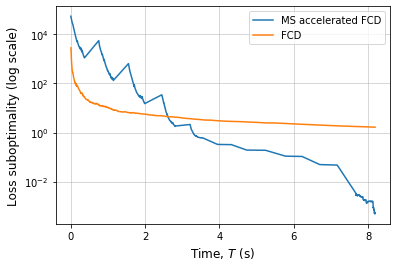

In [10]:
plt.semilogy((np.array(ms_times) - ms_times[0])[:ms_times_max_idx], (losses_ms_times - f_opt)[:ms_times_max_idx], 
             label="MS accelerated FCD")
plt.semilogy(times[:times_max_idx], (losses_times - f_opt)[:times_max_idx], label="FCD")

plt.grid(linewidth=0.5)

plt.xlabel(r"Time, $T$ (s)", fontsize=12)
plt.ylabel(r"Loss suboptimality (log scale)", fontsize=12)
plt.legend()